In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
import re
import time
from scripts.prepare_data_helpers import prepare_examples, create_query
import spacy
import textacy
from dotenv import load_dotenv

load_dotenv()
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.cluster import KMeans
import kmedoids

/Users/marcbraun/.conda/envs/732A81-Text_Mining/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Data

In [2]:
train1 = pd.read_csv('../../e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../../e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../../e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../../e-SNLI/dataset/esnli_test.csv')

train = train.dropna(subset=['Sentence1', 'Sentence2', 'Explanation_1'])
train = train.reset_index(drop=True)

np.random.seed(12345) # seed for numpy package
test_indices = list(np.random.choice(test.index.values, size=1000, replace=False))
test = test.loc[test_indices]
test = test.reset_index(drop=True)

In [3]:
gpt_pred = pd.read_csv("../output_data/svo_structure_4.csv", sep=";")
gpt2 = pd.read_csv("../output_data/svo_structure_gpt2.csv", sep=";")

# Transform list to single string

# GPT-3
gpt_pred.reduced_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.reduced_expl]
gpt_pred.pos_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.pos_expl]

# Gold Explanations
gpt_pred.reduced_gold_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.reduced_gold_expl]
gpt_pred.pos_gold_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.pos_gold_expl]

# GPT-2
gpt2.reduced_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt2.reduced_expl]
gpt2.pos_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt2.pos_expl]
gpt2["pred_label"] = gpt2.labels
gpt2_label_mapping = {0: "contradiction", 1: "neutral", 2: "entailment"}
inverse_gpt2_label_mapping = {"contradiction": 0, "neutral": 1, "entailment": 2}

# GPT-3

## SVO Structure

In [4]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.reduced_expl)

In [5]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


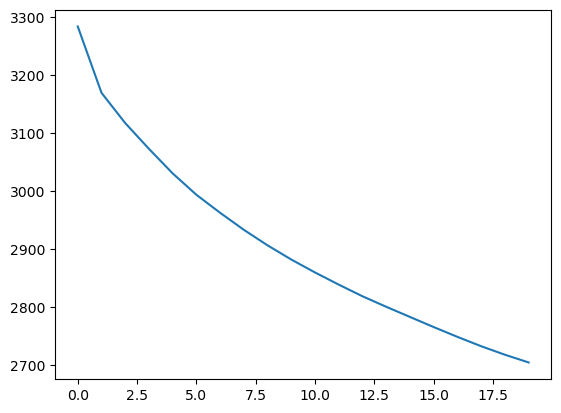

In [6]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [7]:
for i in range(len(SSD)):
    print("------------------")
    print(gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl)
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
S1S2_Subj S1_Verb not imply S2_Verb S2_Obj
Medoid class: contradiction
contradiction    4
neutral          3
Name: pred_label, dtype: int64
------------------
S1S2_Subj not walk S1_Verb S2_Verb same
Medoid class: contradiction
contradiction    8
Name: pred_label, dtype: int64
------------------
S1_Subj S1_Verb imply
Medoid class: entailment
entailment       14
contradiction     6
Name: pred_label, dtype: int64
------------------
be not same
Medoid class: contradiction
contradiction    29
Name: pred_label, dtype: int64
------------------
imply S1S2_Subj S1S2_Verb
Medoid class: entailment
entailment       39
neutral           1
contradiction     1
Name: pred_label, dtype: int64
------------------
S1_Subj be
Medoid class: entailment
entailment       28
contradiction    11
neutral           7
Name: pred_label, dtype: int64
------------------
be S2_Verb S2_Obj
Medoid class: entailment
entailment       20
contradiction     5
neutral           1
Name: pred_label, dtype: int

In [8]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl for i in range(len(SSD))])

['S1S2_Subj S1_Verb not imply S2_Verb S2_Obj', 'S1S2_Subj not walk S1_Verb S2_Verb same', 'S1_Subj S1_Verb imply', 'be not same', 'imply S1S2_Subj S1S2_Verb', 'S1_Subj be', 'be S2_Verb S2_Obj', 'imply S1_Subj', 'be be', 'imply S2_Subj S2_Verb S2_Obj', 'be different', 'S1_Verb S1_Obj be', 'imply S1S2_Subj S2_Verb S2_Obj', 'be', 'S1_Verb S2_Verb S2_Obj be different', '', 'S2_Verb', 'S2_Subj not mean S2_Verb S2_Obj', 'imply', 'not mean']


## POS Structure

In [9]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.pos_expl)

In [10]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


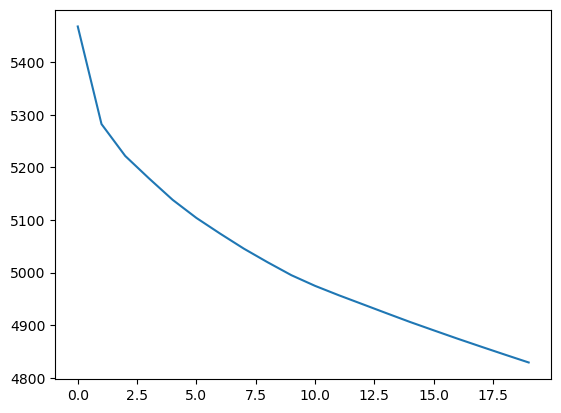

In [11]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [12]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: A mechanic would be performing auto repair.
SVO Structure: perform S1_Verb S1_Obj
POS Structure: S2_NOUN be S1_VERB S1_NOUN S1_NOUN
Medoid class: entailment
entailment       19
contradiction    18
neutral           7
Name: pred_label, dtype: int64
------------------
Actual Expl: If the person is falling off a surfboard, then they are in the water.
SVO Structure: S1_Subj be S1_Verb be
POS Structure: S1S2_NOUN be S1_VERB S1_NOUN be S2_NOUN
Medoid class: entailment
entailment       15
contradiction     5
neutral           1
Name: pred_label, dtype: int64
------------------
Actual Expl: The statement does not describe a white man in a blue uniform pushing away a black man in a red uniform while the two play soccer on a green field.
SVO Structure: not describe S1_Obj S1_Verb S1_Obj
POS Structure: statement not describe S1_ADJ S1_NOUN S1_ADJ S1_NOUN S1_VERB S1_ADP S1_ADJ S1_NOUN S1_ADJ S1_NOUN S1_NOUN S1_NOUN S1_ADJ S1_NOUN
Medoid class: contradiction
entailme

In [13]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl for i in range(len(SSD))])

['S2_NOUN be S1_VERB S1_NOUN S1_NOUN', 'S1S2_NOUN be S1_VERB S1_NOUN be S2_NOUN', 'statement not describe S1_ADJ S1_NOUN S1_ADJ S1_NOUN S1_VERB S1_ADP S1_ADJ S1_NOUN S1_ADJ S1_NOUN S1_NOUN S1_NOUN S1_ADJ S1_NOUN', 'S1S2_NOUN be S1_VERB S1_ADJ S1_NOUN', 'S1S2_NOUN not be S1_VERB S1_NOUN S2_VERB S2_NOUN time', 'S1_VERB S1_NOUN S2_VERB S2_NOUN be different activity', 'S1S2_NOUN be S1_VERB S1_NOUN not S2_VERB S2_NOUN', 'statement imply S1S2_NOUN be S1S2_VERB', 'S1_VERB be S2_VERB', 'S1_NOUN S1_NOUN be not S2_NOUN', 'S1S2_NOUN S1_VERB S1_NOUN S1_NOUN not imply be S2_VERB S2_NOUN', 'S1S2_NOUN not be S1_VERB S2_VERB time', 'S1_NOUN be S2_NOUN', 'S1_VERB S1S2_NOUN be S2_VERB S1S2_NOUN', 'S1_VERB S1_NOUN be not S2_VERB S2_NOUN', 'S1S2_NOUN be S1S2_VERB S1_NOUN S1_NOUN', 'S1_NOUN S2_NOUN be different S1_NOUN', 'S1S2_NOUN be S1S2_NOUN S1_VERB', 'S1S2_NOUN be S1S2_VERB S1S2_NOUN', 'not S2_NOUN S1_NOUN']


## Full Explanations

In [19]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.pred_explanation)

In [20]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


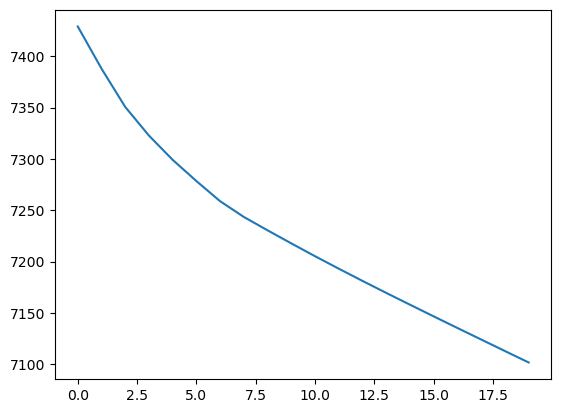

In [21]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [22]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: Standing and playing are two different activities.
SVO Structure: S1_Verb be different
POS Structure: S1_VERB playing be different activity
Medoid class: contradiction
contradiction    24
Name: pred_label, dtype: int64
------------------
Actual Expl: The man is wearing a shirt.
SVO Structure: S1_Subj wear S1_Verb S1S2_Obj
POS Structure: S1_NOUN be S1_VERB S1S2_NOUN
Medoid class: contradiction
entailment       54
contradiction    22
neutral          15
Name: pred_label, dtype: int64
------------------
Actual Expl: The beach is outdoors.
SVO Structure: be
POS Structure: S1_NOUN be S2_ADV
Medoid class: entailment
entailment       300
contradiction    138
neutral           97
Name: pred_label, dtype: int64
------------------
Actual Expl: Six people being led in a straight line across a sandy slope with mountains in the background is an example of many people being led through the desert on the backs of camels.
SVO Structure: S1S2_Subj be S2_Verb be S1S2_Subj

In [23]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation for i in range(len(SSD))])

['Standing and playing are two different activities.', 'The man is wearing a shirt.', 'The beach is outdoors.', 'Six people being led in a straight line across a sandy slope with mountains in the background is an example of many people being led through the desert on the backs of camels.', 'The two statements are contradictory as the first statement describes a woman reading and drinking in the sun while the second statement describes her running through the waves.', 'The statement implies the man is wearing dark knee boots, a green cape, and a hat with two big feathers on the front and has a blue and white patterned piece of wheeled luggage to his right.', 'The first sentence implies that there are two soccer players, and the second sentence confirms that there are two soccer players.', 'The statement describes the man wearing his hat on his head, while the other statement describes the man wearing his hat on his foot.', 'The statement contradicts the original statement as the people 

# GPT-2 Explanations

## SVO Structure

In [24]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt2.reduced_expl)

In [25]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


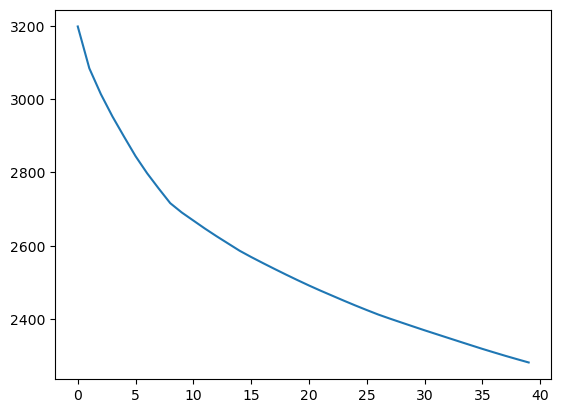

In [26]:
SSD = list()
for k in range(1,41):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [27]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].Explanation_1}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_gold_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_gold_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].gold_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: If a woman has a smile on her face then she is not crying sadly.
SVO Structure: S1S2_Subj S1_Subj not cry
POS Structure: S1S2_NOUN S1_NOUN S1_NOUN be not S2_VERB sadly
Medoid class: contradiction
contradiction    26
entailment       23
neutral          10
Name: pred_label, dtype: int64
------------------
Actual Expl: Just because the couple is enjoying a mean, it does not necessary mean that they are eating steak.  Enjoying a mean, does not necessarily mean that they are, "eating."
SVO Structure: mean not mean S2_Obj mean not mean
POS Structure: S1_NOUN be S1_VERB mean not necessary mean be eat S2_NOUN  S1_VERB mean not necessarily mean be eat
Medoid class: neutral
entailment       14
contradiction     9
neutral           7
Name: pred_label, dtype: int64
------------------
Actual Expl: A bicycle and a bike, are the same object.
SVO Structure: S1_Obj S2_Obj be same
POS Structure: S1_NOUN S2_NOUN be object
Medoid class: entailment
contradiction    14
entai

In [28]:
print([gpt2.iloc[kmfit.medoid_indices_[i]].reduced_expl for i in range(len(SSD))])

['be not', 'S1_Verb S1_Obj imply', 'be S2_Subj', 'S1S2_Subj', 'not imply', 'S1S2_Subj be S1S2_Subj', 'not play S2_Verb S2_Obj', 'not imply S2_Verb', 'S1S2_Subj not stand S1_Verb S2_Verb same', 'S1S2_Subj not mean S2_Verb S2_Obj', 'be different', 'S1S2_Subj S1_Verb not mean S2_Verb', 'S1S2_Subj use S1S2_Verb S1S2_Obj', 'be not S2_Subj', 'S1_Subj S1_Verb not mean', 'S1S2_Subj sit S1S2_Verb sit S1S2_Verb', 'not mean', 'be', 'S1S2_Subj S1S2_Obj help S1S2_Verb S1S2_Subj S1S2_Obj S1S2_Subj S1S2_Obj help S1S2_Verb S1S2_Subj S1S2_Obj S1_Subj S1_Verb', 'play S1S2_Verb S1_Obj play S1S2_Verb S2_Obj', 'S1_Subj be S1_Subj', 'S1_Subj be not', 'not be', 'not walk S2_Verb', 'be S1_Subj', 'S1S2_Subj not repair S1_Verb S1_Obj S2_Verb S2_Obj same', 'S1S2_Subj S1S2_Verb be same S1S2_Subj be S1S2_Verb', 'S1S2_Subj not walk S1_Verb S2_Verb same', 'S1_Subj not be same', 'S1_Subj be S2_Subj', 'be S2_Obj', 'S1_Subj be', 'S2_Subj not sit S2_Verb S1_Verb', 'be be', 'S1_Subj S1_Verb S1_Obj not mean', 'not be same

## POS Structure

In [29]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt2.pos_expl)

In [30]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


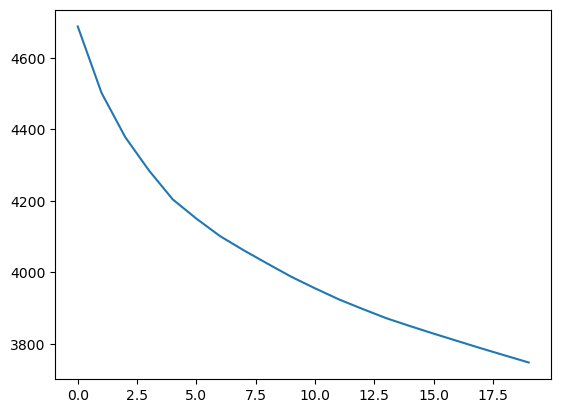

In [31]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [32]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].Explanation_1}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_gold_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_gold_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].gold_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: If the man gets the skateboard on the big rock, the skateboarder would be near a rock.
SVO Structure: S1_Subj S1_Verb S1_Obj be
POS Structure: S1_NOUN S1_VERB S1_NOUN S1_ADJ S1S2_NOUN S2_NOUN be S2_ADP S1S2_NOUN
Medoid class: entailment
entailment       9
contradiction    4
neutral          2
Name: pred_label, dtype: int64
------------------
Actual Expl: The roadside workers are men and are wearing lime green jackets.
SVO Structure: be S2_Subj be S2_Verb S2_Obj
POS Structure: S1_NOUN S1_NOUN be S2_NOUN be S2_VERB S1S2_NOUN S1S2_ADJ S1S2_NOUN
Medoid class: entailment
entailment       20
contradiction     9
neutral           3
Name: pred_label, dtype: int64
------------------
Actual Expl: Not all people are bicyclers. They might not be carrying their bikes at night, it could be daytime.
SVO Structure: be S1_Subj be S1S2_Verb S1S2_Obj be
POS Structure: not people be S1_NOUN not be S1S2_VERB S1S2_NOUN S2_NOUN be daytime
Medoid class: neutral
entailment      

In [33]:
print([gpt2.iloc[kmfit.medoid_indices_[i]].pos_expl for i in range(len(SSD))])

['S1_NOUN S1_NOUN be not necessarily S2_NOUN', 'S1_ADJ S1_NOUN be S2_NOUN', 'S1_ADJ S1S2_NOUN be S1S2_NOUN', 'S1S2_NOUN not be S1S2_VERB S1_NOUN S2_NOUN time', 'S2_NOUN be not S1_NOUN', 'S1S2_NOUN be S1_VERB S1_NOUN not mean be S2_VERB S2_NOUN', 'S1S2_NOUN not be S1_VERB S2_VERB time', 'S1_NOUN S1_NOUN be S2_NOUN', 'S1_NOUN be S2_NOUN', 'not S1S2_NOUN be S2_ADJ', 'S1_VERB S1_NOUN not imply S2_VERB S2_NOUN', 'S1S2_NOUN not be S1_VERB S1_NOUN S2_VERB S2_NOUN time', 'S1_NOUN be', 'S1S2_NOUN be not necessarily S2_VERB S2_NOUN', 'be S2_NOUN', 'S1_NOUN be not S2_NOUN', 'S1S2_NOUN be S1S2_VERB S1S2_NOUN S1S2_NOUN', 'S1_VERB S1S2_NOUN be S2_VERB S1S2_NOUN', 'S1S2_NOUN not be S2_VERB S2_NOUN S1_VERB S1_NOUN', 'S1S2_NOUN be S1S2_NOUN']


## Full Explanations

In [34]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt2.generated)

In [35]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


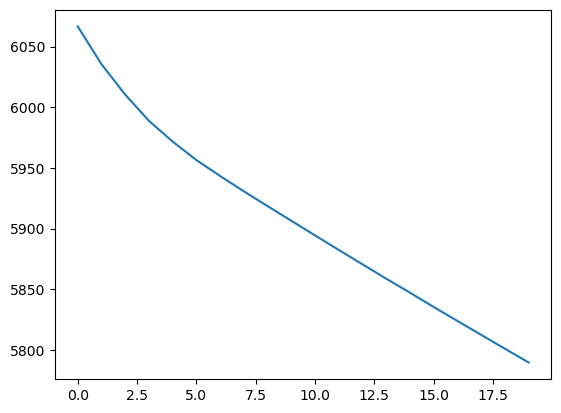

In [36]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [37]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: Hammering nails is a form of repair.
SVO Structure: S1_Verb S1_Obj be S2_Obj
POS Structure: S1_VERB S1_NOUN be form S2_NOUN
Medoid class: entailment
entailment    1
Name: pred_label, dtype: int64
------------------
Actual Expl: The two statements are not related, and wearing hats with colored streamers does not indicate that the children are waiting in line for the bus.
SVO Structure: not relate S1_Verb S1_Obj not S1_Subj S2_Verb
POS Structure: statement be not relate S1_VERB S1_NOUN S1_ADJ S1_NOUN not indicate S1_NOUN be S2_VERB S2_NOUN S2_NOUN
Medoid class: contradiction
entailment       13
contradiction     9
neutral           2
Name: pred_label, dtype: int64
------------------
Actual Expl: The statement is true, the other woman unloading skis is not mentioned.
SVO Structure: S1_Subj S1_Verb S1_Obj not mention
POS Structure: statement be true S1S2_NOUN S1_VERB S1_NOUN be not mention
Medoid class: entailment
entailment    1
Name: pred_label, dtype: int

In [38]:
print([gpt2.iloc[kmfit.medoid_indices_[i]].generated for i in range(len(SSD))])

['Two chefs in an Asian restaurant one cooking on a hibachi type girl the other standing by the refrigerators smiling for the camera does not indicate that they are waiting in line at the retail store.', 'A boy is a child.', 'A young woman peers at an object in her hand is the same as a young woman peers at an object in her hand.', 'A man is a person.', 'Not all older men are a tradesman. Not all older men sawing a piece of metal on the edge is cutting a piece of metal for his newest project.', "Four people are standing together, with two people signing while the other two are looking at them. while in the same moment wouldn't be  there is a group of four people", 'A dog cannot be running and sleeping at the same time.', 'screw', 'Walking is not the same as running.', 'A fully-padded hockey player sits on the ice holding his stick is same as Fully-padded hockey player sits on ice holding stick', 'The woman and child are not necessarily mom and her son. The child is not necessarily her 

# Gold Explanations

## SVO Structure

In [39]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.reduced_gold_expl)

In [40]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


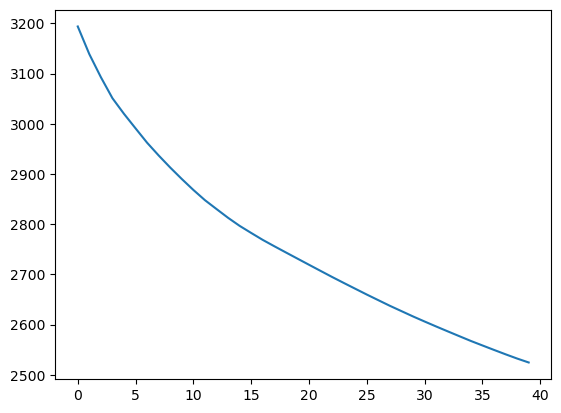

In [41]:
SSD = list()
for k in range(1,41):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [42]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].Explanation_1}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_gold_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_gold_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].gold_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: The subject is either a boy or girl.
SVO Structure: be S1_Subj S2_Subj
POS Structure: subject be S1_NOUN S2_NOUN
Medoid class: contradiction
contradiction    9
entailment       4
neutral          1
Name: pred_label, dtype: int64
------------------
Actual Expl: Playing with an art display does not imply swearing at an art display.
SVO Structure: S1_Verb not imply S2_Verb
POS Structure: S1_VERB S1S2_NOUN S1S2_NOUN not imply S2_VERB S1S2_NOUN S1S2_NOUN
Medoid class: neutral
neutral          5
entailment       2
contradiction    1
Name: pred_label, dtype: int64
------------------
Actual Expl: The woman can't be walking while running.
SVO Structure: S1S2_Subj not walk S1_Verb S2_Verb
POS Structure: S1S2_NOUN not be S1_VERB S2_VERB
Medoid class: contradiction
contradiction    8
Name: pred_label, dtype: int64
------------------
Actual Expl: Answer; The third boy is the another boy
SVO Structure: S1S2_Subj S1S2_Subj S1S2_Subj S1S2_Subj be S1S2_Subj S1S2_Subj S1S

In [43]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_gold_expl for i in range(len(SSD))])

['be S1_Subj S2_Subj', 'S1_Verb not imply S2_Verb', 'S1S2_Subj not walk S1_Verb S2_Verb', 'S1S2_Subj S1S2_Subj S1S2_Subj S1S2_Subj be S1S2_Subj S1S2_Subj S1S2_Subj S1S2_Subj', 'not mean', 'S1_Subj be S2_Subj', 'S2_Subj S2_Verb', 'S2_Subj not be S1_Subj S1_Subj be not S1_Verb S1_Subj be S2_Verb S2_Subj be not S1_Subj S1_Subj S1_Verb not S1_Subj S1_Verb', 'S1_Verb S1_Obj not mean', 'imply S2_Verb S2_Obj', 'be be', 'be S2_Subj be', 'S1_Subj not be', 'S1S2_Subj walk S1S2_Verb walk S1S2_Verb', 'S2_Obj be', 'be not', 'S1_Subj be', 'be S2_Verb be S2_Verb', 'not imply S2_Verb S2_Verb S2_Verb S2_Verb not S2_Verb S2_Verb S2_Subj S2_Verb', 'be S1S2_Subj S1S2_Verb', 'S1_Subj be be', 'not infer', 'be different', 'S1_Subj be S1_Subj be', 'S1S2_Subj S1_Verb not mean S2_Verb', 'laugh S2_Verb S1S2_Subj laugh S2_Verb S1S2_Subj S1S2_Verb S1S2_Obj laugh S2_Verb laugh S2_Verb', 'not be', 'not imply', 'imply', 'S1S2_Subj not play S1S2_Verb S1_Obj S2_Obj same', 'have', 'not smile S2_Verb S1_Subj S1_Verb S1_V

## POS Structure

In [44]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.pos_gold_expl)

In [45]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


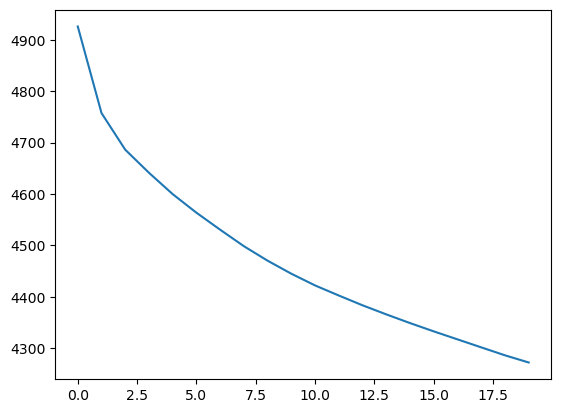

In [46]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [47]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].Explanation_1}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_gold_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_gold_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].gold_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: A little girl is a kid.
SVO Structure: be S2_Subj
POS Structure: S1_ADJ S1_NOUN be S2_NOUN
Medoid class: entailment
entailment       25
neutral           9
contradiction     9
Name: pred_label, dtype: int64
------------------
Actual Expl: You can not infer it's his brother.
SVO Structure: be S2_Subj
POS Structure: not infer be S2_NOUN
Medoid class: neutral
neutral          9
entailment       7
contradiction    2
Name: pred_label, dtype: int64
------------------
Actual Expl: A girl is a girl.
SVO Structure: S1_Subj be S1_Subj
POS Structure: S1S2_NOUN be S1S2_NOUN
Medoid class: entailment
entailment       70
neutral          11
contradiction     8
Name: pred_label, dtype: int64
------------------
Actual Expl: Just because the woman is staring in to the right does not mean she is looking at a dog.
SVO Structure: S1S2_Subj S1_Verb not mean S2_Verb
POS Structure: S1S2_NOUN be S1_VERB S1_NOUN not mean be S2_VERB S2_NOUN
Medoid class: neutral
neutral          6

In [48]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_gold_expl for i in range(len(SSD))])

['S1_ADJ S1_NOUN be S2_NOUN', 'not infer be S2_NOUN', 'S1S2_NOUN be S1S2_NOUN', 'S1S2_NOUN be S1_VERB S1_NOUN not mean be S2_VERB S2_NOUN', 'S1S2_NOUN S1S2_VERB S1S2_NOUN', 'S1_VERB be S2_VERB', 'not be S2_VERB S2_NOUN', 'S1_NOUN be S2_NOUN', 'S1_NOUN S1_NOUN S1_NOUN be not S2_NOUN', 'S1S2_NOUN not be S1_VERB S2_VERB', 'S1S2_NOUN be S1S2_VERB', 'be S1_NOUN S2_NOUN', 'S1S2_NOUN be S1S2_VERB S1S2_NOUN S1S2_NOUN', 'be S1_NOUN', 'S1S2_NOUN be not necessarily S2_VERB S2_NOUN', 'S1_NOUN be not S2_NOUN', 'not be S1_VERB S1_NOUN S2_VERB S2_NOUN', 'S1_NOUN not be S2_NOUN', 'S1S2_NOUN not be', 'S1S2_NOUN S1S2_NOUN S1_NOUN']


## Full Explanations

In [49]:
vectorizer = CountVectorizer(ngram_range=(1, 4))
X = vectorizer.fit_transform(gpt_pred.Explanation_1)

In [50]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


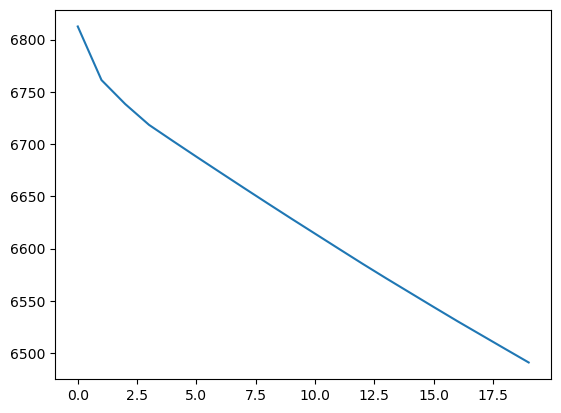

In [51]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [52]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: Running and being chased by another dog refers to the same action.
SVO Structure: S2_Verb S2_Subj refer same
POS Structure: S1S2_VERB be S1S2_VERB S1S2_NOUN refer action
Medoid class: entailment
entailment    1
Name: pred_label, dtype: int64
------------------
Actual Expl: The sentences are essentially saying the same thing.
SVO Structure: say same
POS Structure: sentence be essentially say thing
Medoid class: entailment
entailment       44
contradiction    29
neutral          18
Name: pred_label, dtype: int64
------------------
Actual Expl: Just because the man in white is watching the man in gray does not necessarily mean he is the superior.
SVO Structure: S1_Subj S1_Verb S1_Subj not mean S1_Obj
POS Structure: S1S2_NOUN S1S2_ADJ be S1_VERB S1S2_NOUN S1S2_ADJ not necessarily mean be S2_ADJ
Medoid class: neutral
neutral    1
Name: pred_label, dtype: int64
------------------
Actual Expl: A man and wife getting married is different from two people going to

In [54]:
print([gpt_pred.iloc[kmfit.medoid_indices_[i]].Explanation_1 for i in range(len(SSD))])

["Dog running indicates that a dog is running; being basically involves running by definition, but 'and' is necessary because the fact that the dog is running was already repeated and the first sentence was incomplete anyway.  Oh, wait, so is the second one.", 'A lady is a woman.', "Wearing a gray uniform and cutting something on the ground doesn't necessarily mean the man is a janitor. Wearing white and watching the man in gray doesn't necessarily mean the other man is the superior.", 'The two people may or may not be a man and wife, and they are not standing at an alter if they are going to a hockey game. Also, the people involved are not man and wife until after they get married, not "as" they get married.', 'The first sentence does not imply that the individual is a woman. The first sentence does not imply that the reason the individual is crouched down is for taking a picture.', 'a boy is a person', "Promoting something could be advocating an idea or encouraging an action. Promoti